In [273]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from astropy.constants import c
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quadrature

%matplotlib inline

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_17283/3140175382.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate $C_l^{\Delta \phi}(r_1, r_2)$

In [274]:
sigma = 0.06 # Standard deviation of the fiducial dndz
z_mean = 0.59 # Central redshift of the fiducial dndz

# Set the range for the integrals over r. If this changes, the normalization of phi(r) will need to be changed too
z_min_int = 0.005
z_max_int = z_mean+2

# Now characterize the perturbations to the dndz
error_on_meanz = 0.017*(1+z_mean) # Error on RedMaGiC mean z, from arXiv:1708.01536
sigma_zshift = error_on_meanz # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = 0 #sigma/10. # Standard deviation of the variations in the width of the distribution
modulation_of_mean_of_draws = 0 # Consider also modulating the mean of these shifts across the sky

In [275]:
# The user input is in redshift units because this is more intuitive. However, we will define our dndzs to be
# Gaussian in comoving distance. So next, we convert to chi
chi_mean_fid = Planck18.comoving_distance(z_mean).value
chi_sigma_fid = Planck18.comoving_distance(z_mean + sigma).value - Planck18.comoving_distance(z_mean).value
chi_min_int = Planck18.comoving_distance(z_min_int).value
chi_max_int = Planck18.comoving_distance(z_max_int).value

sigma_chishift = Planck18.comoving_distance(z_mean + sigma_zshift).value - Planck18.comoving_distance(z_mean).value
sigma_chiwidth = Planck18.comoving_distance(z_mean + sigma_zwidth).value - Planck18.comoving_distance(z_mean).value

In [276]:
# Suppose the dndz changes across different healpixels
nside = 8 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r (r is comoviing distance throughout)
n_samples_of_chi = 2**10 # Choose a power of 2
chi_array = np.linspace(chi_min_int,chi_max_int+100,n_samples_of_chi) 

# Get the redshift corresponding to these values of chi in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_chi))
for i, chi in enumerate(chi_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, chi* u.Mpc) 

In [277]:
toy_model = False # If True, seed perturbations only for one Y_{lm}. If False, draw from indep. Gaussians in each pixel

if toy_model:
    # Excite only the l=1, m=1 mode
    l_seeded = 1
    m_seeded = 1
    lmax_bigpix = 20
    dummy_alm = np.zeros(hp.Alm.getsize(lmax_bigpix), dtype=complex)
    dummy_alm[hp.Alm.getidx(lmax_bigpix, l_seeded, m_seeded)] = 1

    modulating_map = hp.alm2map(dummy_alm, nside)
    # Ensure the perturbation map has the correct normalization max(|Y_11|)=np.sqrt(3/(8*np.pi)) 
    modulating_map *= np.sqrt(3/(8*np.pi)) /np.max(np.abs(modulating_map))
    # Multiply the normalized Y_{11} by a small constant
    modulating_map *= sigma_chishift
    # shift of the peak of the distribution, with units of Mpc
    epsilon = sigma_chishift
    hp.mollview(modulating_map, title=r'Shift in $\chi_0$ [Mpc]')
    plt.show()

    # Draw random values in each pixel for the shift of the central redshift of the dndz
    chimean_shifts_array = modulating_map 
    width_shifts_array = np.random.normal(loc=0, scale=0, size=npix)
else:
    # Draw random values in each pixel for the shift of the central redshift of the dndz
    chimean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_chishift, size=npix)
    width_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_chiwidth, size=npix)

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (3001) exceeded. Latest difference = 6.088065e-13
  warnings.warn(


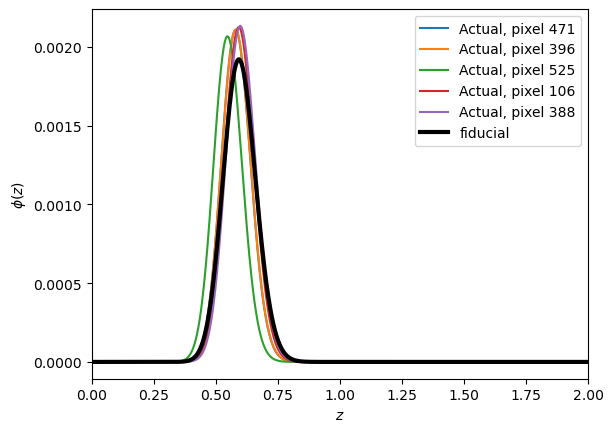

In [278]:
# In each pixel, calculate the perturbed dndz as a Gaussian in chi
dndz_perturbed = (1/((chi_sigma_fid+width_shifts_array[..., np.newaxis])*np.sqrt(2*np.pi))) * np.exp(-(chi_array - chi_mean_fid - chimean_shifts_array[..., np.newaxis])**2 /(2*(chi_sigma_fid+width_shifts_array[..., np.newaxis])**2))
# Take the fiducial dndz to be the monopole of the perturbed dndz
dndz_fid = np.mean(dndz_perturbed, axis=0)

# Convert dndz to selection function
phi_perturbed_array = (Planck18.H(z_array[0,:]) / c).value * dndz_perturbed
phi_fid_array = (Planck18.H(z_array[0,:]) / c).value * dndz_fid

# Normalize the selection function so that \int_{0}^{inf} dr phi(r) = 1
phi_norm, error = quadrature(interp1d(chi_array, phi_fid_array), chi_min_int, chi_max_int, tol=1e-20, miniter=3000)
phi_perturbed_array *= phi_norm**(-1)
phi_fid_array *= phi_norm**(-1)
dndz_fid_normed = dndz_fid / phi_norm
phi_fid = interp1d(chi_array, phi_fid_array)

# Extract the perturbation
delta_p_maps = phi_perturbed_array - phi_fid_array

# Plot some typical realizations
for pixel_id in np.random.randint(0,npix,5):
    plt.plot(z_array[0,:], phi_perturbed_array[pixel_id,:], label='Actual, pixel {}'.format(pixel_id))

# Plot the fiducial dndz
plt.plot(z_array[0,:], phi_fid_array, color='k', lw=3, label='fiducial')

plt.ylabel(r'$\phi(z)$')
plt.xlabel(r'$z$')
plt.xlim([0,2])
plt.legend()

Text(0, 0.5, '$\\langle \\Delta \\phi (z) \\rangle$')

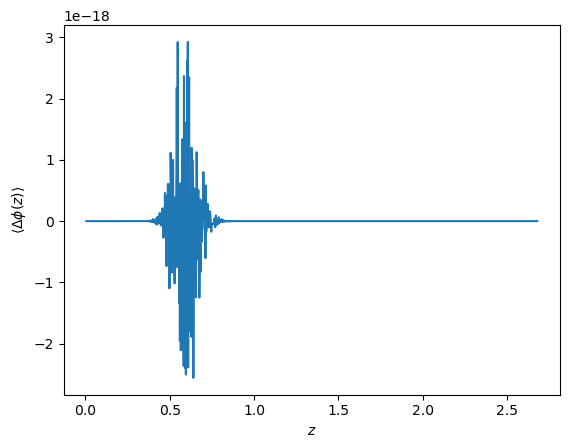

In [279]:
# Make sure that \delta \phi has no monopole
plt.plot(z_array[0,:], np.mean(delta_p_maps, axis=0))
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle \Delta \phi (z) \rangle$')

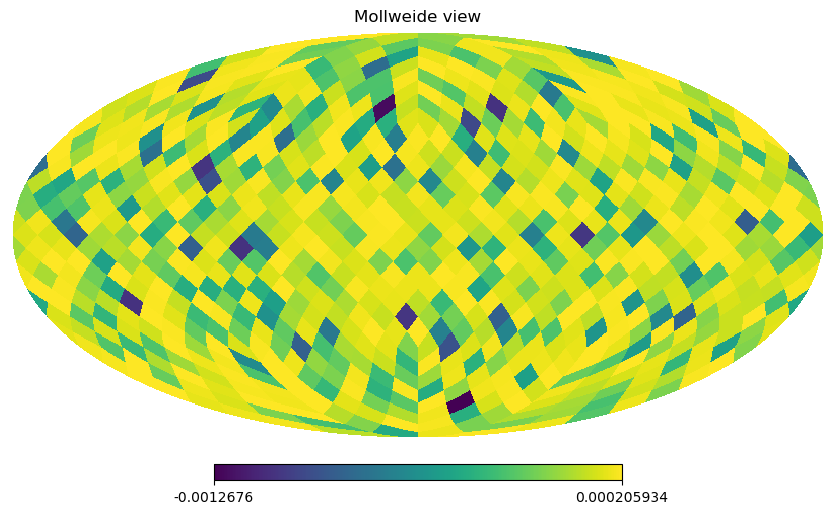

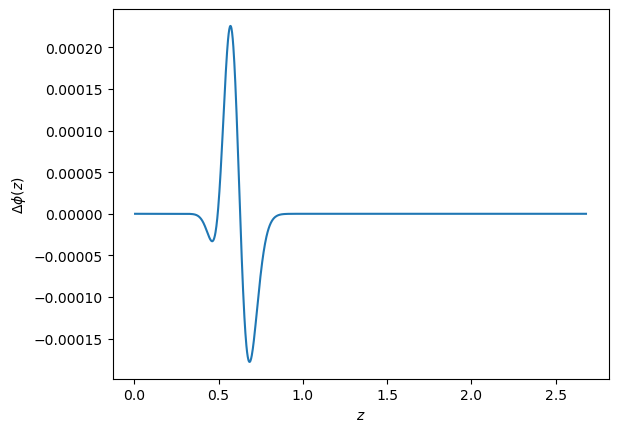

In [280]:
 # Plot a map of an chi-slice where we expect significant fluctuations
chi_mean_idx = np.where(chi_array>chi_mean_fid)[0][0]
hp.mollview(delta_p_maps[:,chi_mean_idx])
plt.show()

# Plot the Delta phi (z) at a random pixel
pix_idx = np.random.randint(0, npix)
plt.plot(z_array[pix_idx,:], delta_p_maps[pix_idx,:])
plt.ylabel(r'$\Delta \phi(z)$')
plt.xlabel(r'$z$')
plt.show()

In [281]:
# Let us up-sample the maps
nside_out = 64 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

delta_p_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_chi))
for i in range(len(chi_array)):
    delta_p_maps_upsampled[:,i] = hp.ud_grade(delta_p_maps[:,i], nside_out)
    
delta_p_maps = delta_p_maps_upsampled

In [282]:
# To avoid ringing due to the hard edges on which we seed the anisotropy, we smooth the maps with a Gaussian 
# with sigma equal to 1/2 of the typical width one of the big pixels (characterized by nside, not nside_out)
sigma_gaussian_smoothing = np.sqrt(4*np.pi/npix)/2. * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

In [283]:
# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
delta_p_lm_of_chi = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_chi), dtype=complex)
for i in range(n_samples_of_chi):
    delta_p_lm_of_chi[:,i] = hp.map2alm(delta_p_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    delta_p_lm_of_chi[:,i] = hp.almxfl(delta_p_lm_of_chi[:,i], beam) 

In [284]:
lmax = hp.Alm.getlmax(delta_p_lm_of_chi.shape[0])
Cl_deltap_of_chi1_chi2 = np.zeros((lmax+1, n_samples_of_chi, n_samples_of_chi))
pixwinf = hp.pixwin(nside_out)[0:lmax+1] # Get the pixel window function for the up-sampled pixelization

for i in range(delta_p_lm_of_chi.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/delta_p_lm_of_chi.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m

    if m!=0:
        # Healpix indexes only m (not -m, since Ylm=Yl-m for a real field), so correct the sum for this
        factor = 2
    else:
        factor = 1

    # Get angular PS and deconvolve pixel window function for all possible combinations of chi1 and chi2 
    Cl_deltap_of_chi1_chi2[l,:,:] += factor*np.outer(delta_p_lm_of_chi[i,:], np.conj(delta_p_lm_of_chi[i,:])).real/ (2*l+1) / pixwinf[l]**2

Completed 0%
Completed 5%
Completed 11%
Completed 16%
Completed 22%
Completed 27%
Completed 32%
Completed 38%
Completed 43%
Completed 49%
Completed 54%
Completed 59%
Completed 65%
Completed 70%
Completed 76%
Completed 81%
Completed 86%
Completed 92%
Completed 97%


## Visualize $C_l^{\Delta \phi \Delta \phi}(\chi)$


(1.0, 5000.0)

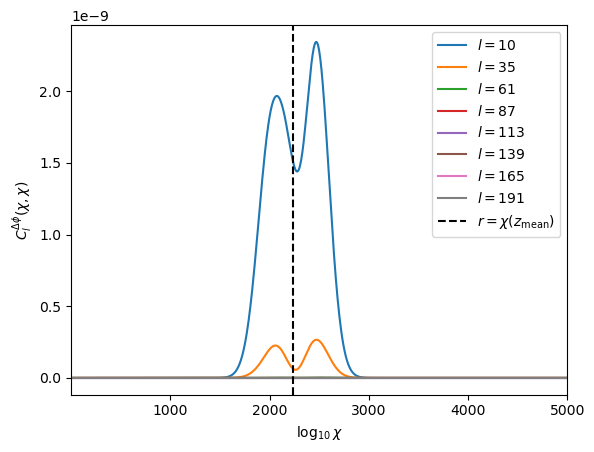

In [285]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.plot(chi_array, np.diagonal(Cl_deltap_of_chi1_chi2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))

if toy_model:
    # The power at the ell that we seeded should dwarf the rest
    plt.plot(chi_array, np.diagonal(Cl_deltap_of_chi1_chi2, axis1=1, axis2=2)[l_seeded,:], label=r'$l={}$'.format(l_seeded))

plt.axvline(chi_mean_fid, ls='--', color='k', label=r'$r=\chi(z_{\mathrm{mean}})$')
plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$C_l^{\Delta \phi}(\chi,\chi)$')
plt.legend()
plt.xlim([1,5000])

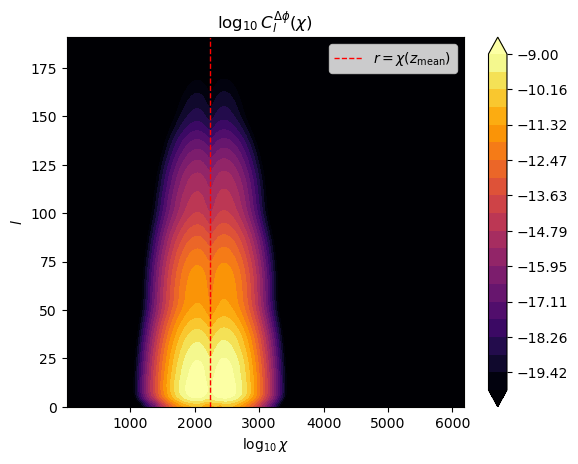

In [621]:
def find_closest_indices(chi_array, ref_array):
    overlapping = np.logical_and(ref_array > np.min(chi_array), ref_array < np.max(chi_array))
    out = np.zeros(np.sum(overlapping))
    for i, a in enumerate(ref_array[overlapping]):
        out[i] = np.abs(chi_array-a).argmin()
    return out.astype(int)

X, Y = np.meshgrid(np.arange(len(chi_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltap_of_chi1_chi2, axis1=1, axis2=2))
# Set the log of 0 to a tiny negative number
Z[np.diagonal(Cl_deltap_of_chi1_chi2, axis1=1, axis2=2)==0] = -1e100

contours = np.linspace(-20,-9,20)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=3)
plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='inferno', extend='both')

ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='r', ls='--', lw=1, label=r'$r=\chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$l$')

label_locs = np.arange(1000,7000,1000, dtype=int)
ax.set_xticks(find_closest_indices(chi_array, label_locs))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_l^{\Delta \phi}(\chi)$')
plt.colorbar(location='right')

If doing the toy model, check how good our approximation is

In [287]:
def integrand_additive_toy_model(r):
    H_of_r = Planck18.H(z_at_value(Planck18.comoving_distance, r* u.Mpc)).value
    return H_of_r*dndz_fid_1deriv(r)

def integrand_conv_bias_toy_model(r, small_l):
    '''
    Integrand for the convolution bias in the toy model. U§ases the Limber approximation.
    Requires globally-defined Pkgg_interp(k), interpolated in k and assumed to be z-idependent
    '''
    H_of_r = Planck18.H(z_at_value(Planck18.comoving_distance, r* u.Mpc)).value
    prefactor = (2*small_l+1) / (4*np.pi) * epsilon**2 / c.value**2 * dndz_fid_1deriv(r)**2 * H_of_r**2
    return prefactor * (1/r)**2 * ( Pkgg_interp((small_l-1+0.5)/r) * wigner_3j(small_l, small_l-1, 1, 0, 0, 0)**2 
                                + Pkgg_interp((small_l+1+0.5)/r) * wigner_3j(small_l, small_l+1, 1, 0, 0, 0)**2  )

if toy_model:
    # Spline interpolate the fiducial phi to then compute the second derivative
    dndz_fid_spl = UnivariateSpline(chi_array, dndz_fid_normed,s=0,k=3)
    dndz_fid_1deriv = dndz_fid_spl.derivative(n=1)
    dndz_fid_2deriv = dndz_fid_spl.derivative(n=2)
   
    # How good is our approximation?
    plt.show()
    plt.plot(chi_array, np.diagonal(Cl_deltap_of_chi1_chi2, axis1=1, axis2=2)[l_seeded,:], ls='-', label='non-perturbative')
    second_order_in_eps = epsilon**2 * (Planck18.H(z_array[0,:]) / c).value**2 * dndz_fid_1deriv(chi_array)**2 /6
    plt.plot(chi_array, second_order_in_eps, label=r'O($\epsilon^2$)', ls='--')

    plt.legend()

## Visualize $C_l^{\Delta \phi \Delta \phi}(\chi_1,\chi_2)$



Let's plot the absolute value of this quantity, fixing one of the $\chi$'s. 

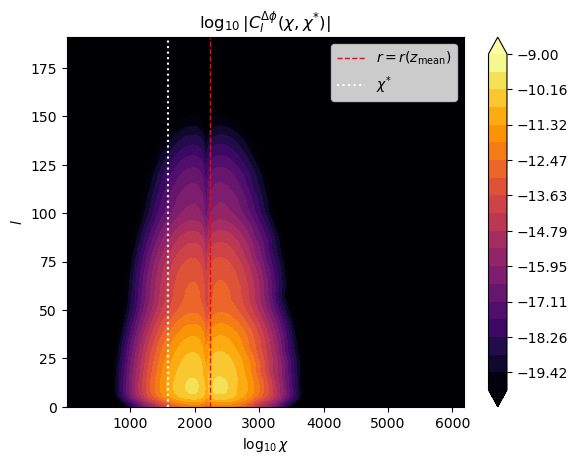

In [622]:
chi_idx = np.where(np.log10(chi_array)>3.2)[0][0]

Z_fixed_chi = np.log10(np.abs(Cl_deltap_of_chi1_chi2[:,:,chi_idx]))
# Set the log of 0 to a tiny negative number
Z_fixed_chi[np.abs(Cl_deltap_of_chi1_chi2[:,:,chi_idx])==0] = -1e100

# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_chi_smoothed = gaussian_filter(Z_fixed_chi, sigma=3)

plt.contourf(X, Y, Z_fixed_chi_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='r', ls='--', lw=1, label=r'$r=r(z_{\mathrm{mean}})$')

ax.set_ylim([0,lmax])

label_locs = np.arange(1000,7000,1000, dtype=int)
ax.set_xticks(find_closest_indices(chi_array, label_locs))
ax.set_xticklabels(label_locs.astype('str'))

plt.title(r'$\mathrm{log}_{10} \, |C_l^{\Delta \phi}(\chi,\chi^{*})|$')
plt.colorbar(location='right')

ax.axvline(chi_idx, label=r'$\chi^{*}$', ls=':', color='w')
plt.legend()


But note that this glosses over the very important fact that, for a fixed $\chi^*$ and $l^*$, $C_{l^*}^{\Delta \phi \Delta \phi}(\chi, \chi*)$ changes sign with $\chi$ in such a way that it will integrate to zero.

(147.0, 579.0)

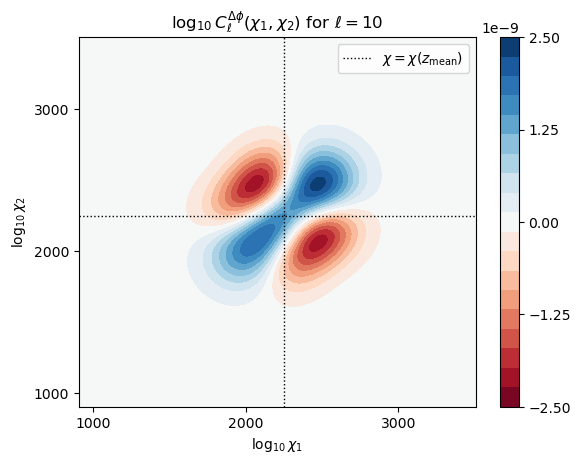

In [617]:
l = 10

contours = np.linspace(-2.5e-9, 2.5e-9, 20)

X, Y = np.meshgrid(np.arange(len(chi_array)), np.arange(len(chi_array)))
Z = Cl_deltap_of_chi1_chi2[l,:,:]

plt.contourf(X, Y, Z, cmap='RdBu', levels=contours, extend='neither')

ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='k', ls=':', lw=1, label=r'$\chi=\chi(z_{\mathrm{mean}})$')
ax.axhline(np.where(chi_array>chi_mean_fid)[0][0], color='k', ls=':', lw=1)

plt.xlabel(r'$\mathrm{log}_{10}\,\chi_1$')
plt.ylabel(r'$\mathrm{log}_{10}\,\chi_2$')

label_locs = np.arange(1000,7000,1000, dtype=int)
ax.set_xticks(find_closest_indices(chi_array, label_locs))
ax.set_yticks(find_closest_indices(chi_array, label_locs))

ax.set_xticklabels(label_locs.astype('str'))
ax.set_yticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_\ell^{\Delta \phi}(\chi_1, \chi_2)$ for $\ell=$'+str(l))
cbar = plt.colorbar(location='right')
cbar_labels = np.linspace(np.min(contours), np.max(contours), 5, dtype=float)
cbar.set_ticks(cbar_labels)

plt.xlim([np.where(chi_array>900)[0][0], np.where(chi_array>3500)[0][0]])
plt.ylim([np.where(chi_array>900)[0][0], np.where(chi_array>3500)[0][0]])

# Get galaxy PS

Get the galaxy auto spectrum to second order in the bias expansion for galaxies resembling DES' redmagic sample

In [292]:
#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

Text(0, 0.5, '$P_{gg}(k)$')

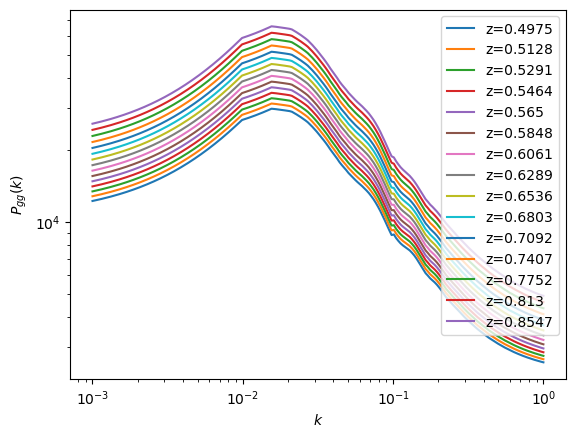

In [373]:
# This cell is copied from Nick Kokron's anzu repository
from anzu.emu_funcs import LPTEmulator
from anzu.utils import _cleft_pk
from anzu.emu_funcs import LPTEmulator
import numpy as np
import pyccl as ccl
from velocileptors.LPT.cleft_fftw import CLEFT
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT

def compute_velocileptors_spectra(cosmovec, snapscale, use_physical_densities=True, 
                                  use_sigma_8=True, kecleft=True, cleftobj=None):
    '''
    Returns a spline object which computes the cleft component spectra. Computed either in
    "full" CLEFT or in "k-expanded" CLEFT which allows for faster redshift dependence.
    Args:
        cosmovec : array-like
            Vector containing cosmology in the order (ombh2, omch2, w0, ns, sigma8, H0, Neff).
            If self.use_sigma_8 != True, then ln(A_s/10^{-10}) should be provided instead of sigma8.
        snapscale : float
            scale factor
        kecleft: bool
            Bool to check if the calculation is being made with 
    Returns:
        cleft_aem : InterpolatedUnivariateSpline 
            Spline that computes basis spectra as a function of k
    '''

    if use_physical_densities:
        if use_sigma_8:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0] / (cosmovec[5] / 100)**2,
                                  Omega_c=cosmovec[1] /
                                  (cosmovec[5] / 100)**2,
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  sigma8=cosmovec[4])
        else:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0] / (cosmovec[5] / 100)**2,
                                  Omega_c=cosmovec[1] /
                                  (cosmovec[5] / 100)**2,
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  A_s=np.exp(cosmovec[4]) * 1e-10)
    else:
        if use_sigma_8:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0],
                                  Omega_c=cosmovec[1] - cosmovec[0],
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  sigma8=cosmovec[4])
        else:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0],
                                  Omega_c=cosmovec[1] - cosmovec[0],
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  A_s=np.exp(cosmovec[4]) * 1e-10)

    k = np.logspace(-3, 1, 1000)

    if kecleft:
        # If using kecleft, check that we're only varying the redshift

        if cleftobj is None:
            # Do the full calculation again, as the cosmology changed.
            pk = ccl.linear_matter_power(
                cosmo, k * cosmo['h'], 1) * (cosmo['h'])**3

            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, pk)

        # Adjust growth factors
        D = ccl.background.growth_factor(cosmo, snapscale)
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        pk = ccl.linear_matter_power(
            cosmo, k * cosmo['h'], snapscale) * (cosmo['h'])**3
        cleftobj = CLEFT(k, pk, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, pk, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    cleftpk[3:, :] = cleftobj.pktable.T[3:, :]
    cleftpk[2, :] /= 2
    cleftpk[6, :] /= 0.25
    cleftpk[7, :] /= 2
    cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')

    return cleftspline, cleftobj

emu = LPTEmulator()

k = np.logspace(-3,0,200)

# Evaluate predictions at the Planck 18 cosmology and redshifts within 7sigma of the dndzmean
zs_sampled = np.linspace(z_mean - 7*sigma, z_mean + 7*sigma, 15)
chis_sampled = Planck18.comoving_distance(zs_sampled).value
for i, z in enumerate(zs_sampled):
    a = 1/(1+z)
    if i==0:
        cosmo_vec = np.atleast_2d([0.0224, 0.120, -1, 0.966, 0.812,  67.32,  3.046,  a]) # Values from Planck 2018
    else:
        cosmo_vec = np.vstack([np.atleast_2d([0.0224, 0.120, -1, 0.966, 0.812,  67.32,  3.046,  a]), cosmo_vec])

lpt_spec = np.zeros((len(cosmo_vec),10,700))

# Evaluate predictions at the relevant redshifts
for i, c in enumerate(cosmo_vec):
    lpt_interp, cleftobk = compute_velocileptors_spectra(c, c[-1],
                                                         use_physical_densities=emu.use_physical_densities,
                                                         use_sigma_8=emu.use_sigma_8, kecleft=False)    
    lpt_spec[i,...] = lpt_interp(emu.k)[1:11,:]
emu_spec = emu.predict(k, cosmo_vec, spec_lpt=lpt_spec)

# Plot
Pkgg = np.zeros((len(k), len(cosmo_vec[:,-1])))
for i, z in enumerate(cosmo_vec[:,-1]):
    Pkgg[:, i] = emu.basis_to_full(k, bvec, emu_spec[i,:,:], halomatter=False)
    plt.loglog(k, Pkgg[:,i], label='z={}'.format(round(z,4)))
plt.legend()

plt.xlabel(r'$k$')
plt.ylabel(r'$P_{gg}(k)$')

# Calculate biases

#### In the Limber approximation

To DO:
- Quantify impact of varying Pgg(z) relative to having it fixed at Pgg(z_mean). Implement for gg lensing as well
- Choose lprime_max more systematically
- Parallelize! (should be rather trivial to do)

First, we'll need to interpolate our spectra

In [ ]:
Pkgg_interp = interpolate.RegularGridInterpolator((k, chis_sampled), Pkgg,
                                   method='linear', bounds_error=False, fill_value=0)

cldp_interp = interp1d(chi_array, np.diagonal(Cl_deltap_of_chi1_chi2, axis1=1, axis2=2), axis=-1)

Calculate the convolutional bias term

In [374]:
def integrand_conv_term(chi, small_l, Pkgg_interp_1Dlimber, prefactor):
    '''
    Integrand for the convolutional bias term in the Limber approximation.
    Requires globally-defined cldp_interp(k)[l], interpolated in k
    Pkgg_interp_1Dlimber = interp1d(chi_array, Pkgg( (L+0.5)/chi_array, z(chi_array) ))
    '''
    return prefactor/ chi**2 * Pkgg_interp_1Dlimber(chi) * cldp_interp(chi)[small_l]

if toy_model:
    lprime_max = 5 #Value of l above which we ignore the anisotropy in C_l^{\Delta \phi}(k)
else:
    lprime_max = 100 #Value of l above which we ignore the anisotropy in C_l^{\Delta \phi}(k)

conv_bias_ells = np.logspace(1.5, 3, 3, dtype=int)
conv_bias = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    for lprime in range(lprime_max):
        for L in np.arange(np.abs(l-lprime), np.abs(l+lprime)+1, 1):
            if (l+lprime+L)%2==0:
                w3 = wigner_3j(l, L, lprime, 0, 0, 0)
                prefactor = float(w3)**2 * (2*lprime+1) * (2*L+1) / (4*np.pi)

                # Interpolate at the scales required by Limber
                X, Y = np.meshgrid((L+0.5)/chi_array, chi_array, indexing='ij')
                Pkgg_interp_1D = interp1d(chi_array, np.diagonal(Pkgg_interp((X,Y))))

                integ, error = quadrature(integrand_conv_term,chi_min_int, chi_max_int, args=(lprime, Pkgg_interp_1D, prefactor), miniter=1000, maxiter=2000, tol=1e-12)
                conv_bias[i] += integ

Working on l=31; iteration 1/3
Working on l=177; iteration 2/3
Working on l=1000; iteration 3/3


Calculate the additive term

In [375]:
def integrand_additive_term(chi1, small_l, Clchi1chi2_interp):
    '''
    Integrand for the additive bias term, in the Limber approximation.
    Requires globally-defined cldp_interp(k1, k2)[l], interpolated in k
    '''
    outer_integral, error = quadrature(integrand_nested_additive_term, chi_min_int, 
                                       chi_max_int, args=(chi1, small_l, Clchi1chi2_interp), miniter=3,
                                             maxiter=5, tol=1e-20)
    return outer_integral

def integrand_nested_additive_term(chi2, chi1, small_l, Clk1k2_interp):
    chi1=chi1[0]
    chi2=chi2[0]
    return Clchi1chi2_interp(np.array((chi1, chi2)))[0]

additive_bias_ells = np.logspace(1, np.log10(lmax-5), 3, dtype=int)
additive_bias = np.zeros_like(additive_bias_ells, dtype=float)

for i, l in enumerate(additive_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(additive_bias_ells)))
    Clchi1chi2_interp = interpolate.RegularGridInterpolator((chi_array,chi_array), Cl_deltap_of_chi1_chi2[l, :, :],
                                   method='linear', bounds_error=True, fill_value=0)

    additive_bias[i], error = quadrature(integrand_additive_term, chi_min_int, chi_max_int, args=(l, Clchi1chi2_interp),
                                         miniter=3, maxiter=5, tol=1e-20)

Working on l=10; iteration 1/3
Working on l=43; iteration 2/3
Working on l=186; iteration 3/3


Get the unbiased Clgg for comparison

In [376]:
def integrand_unbiased_auto_term(chi, Pkgg_interp_1D):
    '''
    Integrand for the unbiased Clgg auto spectrum in the Limber approximation.
    Requires globally-defined Pkgg_interp_1D(chi)
    '''
    return Pkgg_interp_1D(chi) * (phi_fid(chi)/chi)**2

clgg_unbiased = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    X, Y = np.meshgrid((l+0.5)/chi_array, chi_array, indexing='ij')
    Pkgg_interp_1D = interp1d(chi_array, np.diagonal(Pkgg_interp((X,Y))))
    clgg_unbiased[i], error = quadrature(integrand_unbiased_auto_term, chi_min_int, 
                                       chi_max_int, args=(Pkgg_interp_1D), miniter=1000, maxiter=2000, tol=1e-12)

Working on l=31; iteration 1/3
Working on l=177; iteration 2/3
Working on l=1000; iteration 3/3


Evaluate the analytic prediction if working with the toy model

In [377]:
def integrand_toy_model_additive(chi):
    H_of_chi = (Planck18.H(z_at_value(Planck18.comoving_distance, chi* u.Mpc))).value
    return H_of_chi*dndz_fid_1deriv(chi)

def integrand_conv_bias_toy_model(chi, small_l):
    '''
    Integrand for the convolution bias in the toy model. Uses the Limber approximation.
    Requires globally-defined Pkgg_interp(k), interpolated in k and assumed to be z-idependent
    '''
    H_of_chi = (Planck18.H(z_at_value(Planck18.comoving_distance, chi* u.Mpc))).value
    second_order_in_eps = epsilon**2 / (8*np.pi*c.value**2) * H_of_chi**2 * dndz_fid_1deriv(chi)**2 * (1/chi)**2 * ( (2*small_l-1)*Pkgg_interp((small_l-1+0.5)/chi) * wigner_3j(small_l, small_l-1, 1, 0, 0, 0)**2 
                                + (2*small_l+3)*Pkgg_interp((small_l+1+0.5)/chi) * wigner_3j(small_l, small_l+1, 1, 0, 0, 0)**2  )
    return second_order_in_eps

if toy_model:
    # Spline interpolate the fiducial phi to then compute the second derivative
    dndz_fid_spl = UnivariateSpline(chi_array, dndz_fid_normed,s=0,k=3)
    dndz_fid_1deriv = dndz_fid_spl.derivative(n=1)
    dndz_fid_2deriv = dndz_fid_spl.derivative(n=2)

    analytic_conv_bias_toy_model = np.zeros_like(conv_bias_ells, dtype=float)

    for i, l in enumerate(conv_bias_ells):
        print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
        analytic_conv_bias_toy_model[i], error = quadrature(integrand_conv_bias_toy_model, chi_min_int, 
                                           chi_max_int, args=(l), maxiter=1000, tol=1e-12)

    # Plot the factor by which the conv bias integrand is suppressed relative to the signal
    H_of_chi = (Planck18.H(z_at_value(Planck18.comoving_distance, chi_array* u.Mpc))).value
    for l in np.arange(10, 2000, 200):
        kernel_bias_minus = wigner_3j(l, l-1, 1, 0, 0, 0)**2  * epsilon**2 * H_of_chi**2 /c.value**2 * (2*l-1)/(8*np.pi) * dndz_fid_1deriv(chi_array)**2
        kernel_bias_plus = wigner_3j(l, l+1, 1, 0, 0, 0)**2  * epsilon**2 * H_of_chi**2 /c.value**2 * (2*l+3)/(8*np.pi) * dndz_fid_1deriv(chi_array)**2
        kernel_signal = H_of_chi**2 / c.value**2 * dndz_fid_spl(chi_array)**2 
        plt.semilogy(chi_array, kernel_bias_minus/kernel_signal, label=r'l={}'.format(l), ls='--')
        plt.semilogy(chi_array, kernel_bias_plus/kernel_signal, label=r'l={}'.format(l), ls='--')

    plt.legend()
    plt.xlabel(r'$\chi$')
    plt.ylabel(r'$\alpha_{-}(\ell,\chi)/\bar{\phi}^2(\chi)$')
    plt.title(r'Suppression factor in the integrand of conv. bias')

    # Calculate also the additive bias -- only non-zero at ell=1
    integral_dphidchi, error = quadrature(integrand_toy_model_additive, chi_min_int, 
                                           chi_max_int, miniter=1000, maxiter=2000, tol=1e-12)
    additive_bias_at_ellequals1 = epsilon**2 / c.value**2 /6. * integral_dphidchi**2

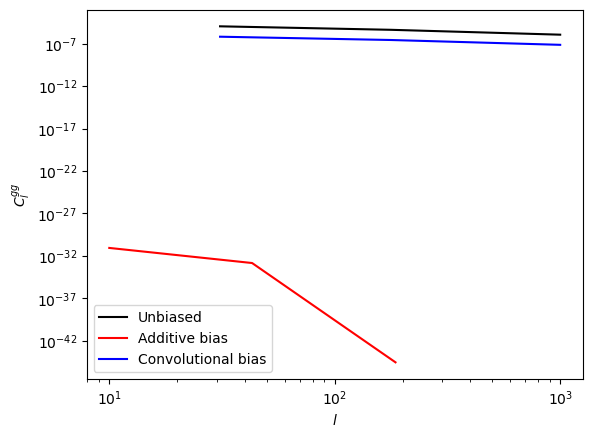

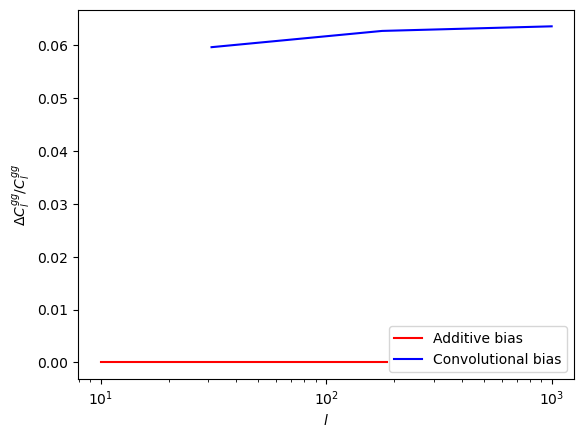

In [379]:
plt.loglog(conv_bias_ells, clgg_unbiased, 'k', label=r'Unbiased')
plt.loglog(additive_bias_ells, additive_bias, 'r', label=r'Additive bias')
plt.loglog(conv_bias_ells, conv_bias, 'b', label=r'Convolutional bias')
if toy_model:
    plt.loglog(conv_bias_ells, analytic_conv_bias_toy_model, 'b', ls='--', label=r'Analytic convolutional bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{gg}$')
plt.legend()

plt.show()

plt.plot(additive_bias_ells, additive_bias/np.interp(additive_bias_ells, conv_bias_ells, clgg_unbiased), 'r', label=r'Additive bias')
plt.plot(conv_bias_ells, conv_bias/clgg_unbiased, 'b', label=r'Convolutional bias')
if toy_model:
    plt.loglog(conv_bias_ells, analytic_conv_bias_toy_model/clgg_unbiased, 'b', ls='--', label=r'Analytic convolutional bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$\Delta C_l^{gg} / C_l^{gg}$')
plt.legend()

plt.xscale('log')